In [1]:
#Python version 3.1 and causica version 3.2
# Posterior versions of causica dont have the ICGNN module

from dataclasses import dataclass

import numpy as np
import networkx as nx

import torch
import pytorch_lightning as pl

from torch.utils.data import DataLoader
from tensordict import TensorDict

from castle.datasets import DAG, IIDSimulation 
from castle.common import GraphDAG
from castle.metrics import MetricsDAG

import causica.distributions as cd

from causica.functional_relationships import *
from causica.training.auglag import AugLagLossCalculator, AugLagLR, AugLagLRConfig
from causica.graph.dag_constraint import calculate_dagness

from causica.datasets.variable_types import VariableTypeEnum
from causica.datasets.tensordict_utils import tensordict_shapes

import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')


from dowhy import gcm
import pandas as pd

/home/flav/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Set device
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [3]:
# Set random seed
SEED = 11
np.random.seed(SEED)
pl.seed_everything(SEED)  

Global seed set to 11


In [4]:
#Causal graph
causal_graph = nx.DiGraph([('d', 'messageReceived'),
                           ('d', 'graft'),
                           ('d', 'prune'),
                           ('d', 'iwant'),
                           ('dlo', 'graft'),
                           ('dhi', 'prune'),
                           ('dscore', 'graft'),
                           ('dscore', 'prune'),
                           ('dlazy', 'iwant'),
                           ('dlazy', 'ihave'),
                           ('dout', 'graft'),
                           ('dout', 'prune'),
                           ('gossipFactor', 'iwant'),
                           ('gossipFactor', 'ihave'),
                           ('interval', 'graft'),
                           ('interval', 'prune'),
                           ('interval', 'iwant'),
                           ('interval', 'ihave'),
                           ('topology', 'graft'),
                           ('topology', 'prune'),
                           ('topology', 'propagationTime'),
                           ('topology', 'messageReceived'),
                           ('prune', 'graft'),
                           ('prune', 'propagationTime'),
                           ('messageReceived', 'messageOverhead'),
                           ('messageOverhead', 'bandwidth'),
                           ('ihave', 'bandwidth'),
                           ('iwant', 'bandwidth')
                         ])

In [5]:
#From digraph to adjancency matrix

# true_causal_matrix = nx.adjacency_matrix(causal_graph)
true_causal_matrix = nx.to_numpy_array(causal_graph)

print(true_causal_matrix)
print(causal_graph.nodes)

# adj_matrix=causal_graph

[[0. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 1. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
['d', 'messageReceived', 'graft', 'prune', 'iwant', 'dlo', 'dhi', 'dscore', 'dlaz

In [6]:
#Treat dataset

#Import data 
# data = pd.read_csv('../datasets/consolidated.csv',header=0, index_col=0)
data = pd.read_csv('../GenerateDatasets/consolidated.csv',header=0, index_col=0)
consolidated = pd.DataFrame(data)

consolidated = consolidated.drop(columns=['experiment', 'messageBandwidth', 'gossipBandwidth'])#, 'messageDuplicated'])#, 'n_nodes', 'consensus', 'messageDuplicated'])
consolidated = consolidated.rename(columns={'topology':'top', 'totalBandwidth':'bandwidth'})
consolidated['topology'] = 0
consolidated.loc[consolidated['top'] == 'general', 'topology'] = 1
consolidated = consolidated.loc[consolidated['bandwidth'] > 0]
consolidated = consolidated.drop(columns=['top'])
# consolidated.head(100)

#Rearrange columns according to nodes list
nodes = causal_graph.nodes

X = consolidated[['d', 'messageReceived', 'graft', 'prune', 'iwant', 'dlo', 'dhi', 'dscore', 'dlazy', 'ihave', 'dout', 'gossipFactor', 
                  'interval', 'topology', 'propagationTime', 'messageOverhead', 'bandwidth']].to_numpy()

# X = consolidated.to_numpy()
print(X)

[[   8.         4226.            0.         ... 1880.40066225
   579.          289.5       ]
 [   8.         3986.            0.         ... 1670.64814815
   542.          271.        ]
 [   8.          472.            0.         ... 1710.70833333
    72.           36.        ]
 ...
 [  21.         1241.            0.         ... 1332.5625
   112.           56.        ]
 [  21.          463.            0.         ...  845.74193548
    42.           21.        ]
 [  21.         1703.            0.         ... 1218.58064516
   154.           77.        ]]


In [7]:
@dataclass(frozen=True)
class TrainingConfig:
 noise_dist=cd.ContinuousNoiseDist.SPLINE
 batch_size=512
 max_epoch=500
 gumbel_temp=0.25
 averaging_period=10
 prior_sparsity_lambda=5.0
 init_rho=1.0
 init_alpha=0.0
training_config = TrainingConfig()
auglag_config = AugLagLRConfig()

In [8]:
# Cast data to torch tensors
data_tensors = {}

for i in range(X.shape[1]):
    data_tensors[f'x{i}'] = torch.tensor(X[:, i].reshape(-1, 1))
    
dataset_train = TensorDict(data_tensors, torch.Size([X.shape[0]]))
    
# Move the entire dataset to the device (for big datasets move to device by batch within training loop)
dataset_train = dataset_train.apply(lambda t: t.to(dtype=torch.float32, device=device))

# Create loader
dataloader_train = DataLoader(
    dataset=dataset_train,
    collate_fn=lambda x: x,
    batch_size=training_config.batch_size,
    shuffle=True,
    drop_last=False,
)

dataset_train

TensorDict(
    fields={
        x0: Tensor(shape=torch.Size([87499, 1]), device=cpu, dtype=torch.float32, is_shared=False),
        x10: Tensor(shape=torch.Size([87499, 1]), device=cpu, dtype=torch.float32, is_shared=False),
        x11: Tensor(shape=torch.Size([87499, 1]), device=cpu, dtype=torch.float32, is_shared=False),
        x12: Tensor(shape=torch.Size([87499, 1]), device=cpu, dtype=torch.float32, is_shared=False),
        x13: Tensor(shape=torch.Size([87499, 1]), device=cpu, dtype=torch.float32, is_shared=False),
        x14: Tensor(shape=torch.Size([87499, 1]), device=cpu, dtype=torch.float32, is_shared=False),
        x15: Tensor(shape=torch.Size([87499, 1]), device=cpu, dtype=torch.float32, is_shared=False),
        x16: Tensor(shape=torch.Size([87499, 1]), device=cpu, dtype=torch.float32, is_shared=False),
        x1: Tensor(shape=torch.Size([87499, 1]), device=cpu, dtype=torch.float32, is_shared=False),
        x2: Tensor(shape=torch.Size([87499, 1]), device=cpu, dtype=t

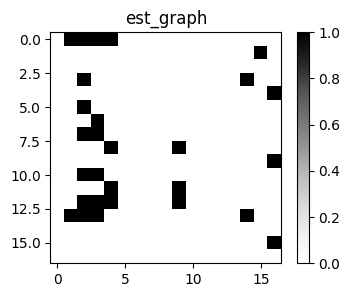

In [9]:
# Plot the true adj matrix
plt.style.use('default')
GraphDAG(true_causal_matrix)
plt.show()

In [10]:
# Encode our strong belief about the existence of the edge (3, 0) 
# And lack of existence of edge (0, 3)
adj_matrix = true_causal_matrix
expert_matrix = torch.tensor(np.zeros(adj_matrix.shape))

# Encode the edge knowledge
expert_matrix[3, 0] = 1.

# Create a relevancew mask
relevance_mask = expert_matrix.clone()
relevance_mask[0, 3] = 1.

# Create a confidence matrix
confidence_matrix = relevance_mask.clone()

In [11]:
# Encapsulate everything within the expert knowledge container
expert_knowledge = cd.ExpertGraphContainer(
    dag=expert_matrix,
    mask=relevance_mask,
    confidence=confidence_matrix,
    scale=5.
)

In [12]:
num_nodes = len(dataset_train.keys())

# Define the prior
prior = cd.GibbsDAGPrior(
    num_nodes=num_nodes, 
    sparsity_lambda=training_config.prior_sparsity_lambda,
    expert_graph_container=expert_knowledge
)

In [13]:
# Define the adjaceny module
adjacency_dist = cd.ENCOAdjacencyDistributionModule(num_nodes)

#Define the functional module
icgnn = ICGNN(
    variables=tensordict_shapes(dataset_train),
    embedding_size=8, #32,
    out_dim_g=8, #32,
    norm_layer=torch.nn.LayerNorm,
    res_connection=True,
)

# Define the noise module
types_dict = {var_name: VariableTypeEnum.CONTINUOUS for var_name in dataset_train.keys()}

noise_submodules = cd.create_noise_modules(
    shapes=tensordict_shapes(dataset_train), 
    types=types_dict, 
    continuous_noise_dist=training_config.noise_dist
)

noise_module = cd.JointNoiseModule(noise_submodules)

In [14]:
noise_submodules

{'x0': SplineNoiseModule(
   (composite_spline_layers): ModuleList(
     (0-1): 2 x CompositeSplineLayer()
   )
 ),
 'x1': SplineNoiseModule(
   (composite_spline_layers): ModuleList(
     (0-1): 2 x CompositeSplineLayer()
   )
 ),
 'x2': SplineNoiseModule(
   (composite_spline_layers): ModuleList(
     (0-1): 2 x CompositeSplineLayer()
   )
 ),
 'x3': SplineNoiseModule(
   (composite_spline_layers): ModuleList(
     (0-1): 2 x CompositeSplineLayer()
   )
 ),
 'x4': SplineNoiseModule(
   (composite_spline_layers): ModuleList(
     (0-1): 2 x CompositeSplineLayer()
   )
 ),
 'x5': SplineNoiseModule(
   (composite_spline_layers): ModuleList(
     (0-1): 2 x CompositeSplineLayer()
   )
 ),
 'x6': SplineNoiseModule(
   (composite_spline_layers): ModuleList(
     (0-1): 2 x CompositeSplineLayer()
   )
 ),
 'x7': SplineNoiseModule(
   (composite_spline_layers): ModuleList(
     (0-1): 2 x CompositeSplineLayer()
   )
 ),
 'x8': SplineNoiseModule(
   (composite_spline_layers): ModuleList(
    

In [15]:
#Treat dataset

#Import data 
# data = pd.read_csv('../datasets/consolidated.csv',header=0, index_col=0)
data = pd.read_csv('../GenerateDatasets/consolidated.csv',header=0, index_col=0)
consolidated = pd.DataFrame(data)

consolidated = consolidated.drop(columns=['experiment'])#, 'messageDuplicated'])#, 'n_nodes', 'consensus', 'messageDuplicated'])
consolidated = consolidated.rename(columns={'topology':'top'})
consolidated['topology'] = 0
consolidated.loc[consolidated['top'] == 'general', 'topology'] = 1
consolidated = consolidated.drop(columns=['top'])
# consolidated.head(100)

#Rearrange columns according to nodes list
nodes = causal_graph.nodes

X = consolidated[['d', 'messageReceived', 'graft', 'prune', 'iwant', 'dlo', 'dhi', 'dscore', 'dlazy', 'ihave', 'dout', 'gossipFactor', 
                  'interval', 'topology', 'propagationTime', 'messageOverhead', 'messageBandwidth', 'totalBandwidth', 'gossipBandwidth']].to_numpy()

# X = consolidated.to_numpy()
print(X)

[[8.00000e+00 4.22600e+03 0.00000e+00 ... 2.89500e+02 2.89500e+02
  0.00000e+00]
 [8.00000e+00 3.98600e+03 0.00000e+00 ... 2.71000e+02 2.71000e+02
  0.00000e+00]
 [8.00000e+00 4.72000e+02 0.00000e+00 ... 3.60000e+01 3.60000e+01
  0.00000e+00]
 ...
 [2.10000e+01 0.00000e+00 0.00000e+00 ... 0.00000e+00 0.00000e+00
  7.89420e+04]
 [2.10000e+01 0.00000e+00 0.00000e+00 ... 0.00000e+00 0.00000e+00
  2.96180e+04]
 [2.10000e+01 0.00000e+00 0.00000e+00 ... 0.00000e+00 0.00000e+00
  1.08973e+05]]


In [16]:
# Combine all SEM modules
sem_module = cd.SEMDistributionModule(
    adjacency_module=adjacency_dist, 
    functional_relationships=icgnn, 
    noise_module=noise_module)

sem_module.to(device)

SEMDistributionModule(
  (adjacency_module): ENCOAdjacencyDistributionModule()
  (functional_relationships): ICGNN(
    (nn): FGNNI(
      (g): Sequential(
        (0): Sequential(
          (0): Linear(in_features=25, out_features=68, bias=True)
          (1): LeakyReLU(negative_slope=0.01)
        )
        (1): _ResBlock(
          (block): Sequential(
            (0): LayerNorm((68,), eps=1e-05, elementwise_affine=True)
            (1): Linear(in_features=68, out_features=68, bias=True)
            (2): LeakyReLU(negative_slope=0.01)
          )
        )
        (2): LayerNorm((68,), eps=1e-05, elementwise_affine=True)
        (3): Linear(in_features=68, out_features=8, bias=True)
        (4): Identity()
      )
      (f): Sequential(
        (0): Sequential(
          (0): Linear(in_features=16, out_features=68, bias=True)
          (1): LeakyReLU(negative_slope=0.01)
        )
        (1): _ResBlock(
          (block): Sequential(
            (0): LayerNorm((68,), eps=1e-05, ele

In [17]:
modules = {
    "icgnn": sem_module.functional_relationships,
    "vardist": sem_module.adjacency_module,
    "noise_dist": sem_module.noise_module,
}

parameter_list = [
    {"params": module.parameters(), "lr": auglag_config.lr_init_dict[name], "name": name}
    for name, module in modules.items()
]

# Define the optimizer
optimizer = torch.optim.Adam(parameter_list)

In [18]:
# Define the augmented Lagrangian loss objects
scheduler = AugLagLR(config=auglag_config)

auglag_loss = AugLagLossCalculator(
    init_alpha=training_config.init_alpha, 
    init_rho=training_config.init_rho
)

/home/flav/.local/lib/python3.10/site-packages/torch/distributions/distribution.py:51: UserWarning: <class 'causica.distributions.noise.joint.JointNoise'> does not define `arg_constraints`. Please set `arg_constraints = {}` or initialize the distribution with `validate_args=False` to turn off validation.
  warnings.warn(f'{self.__class__} does not define `arg_constraints`. ' +


epoch:0 loss:5.8005e+06 nll:5.8005e+06 dagness:32.17364 num_edges:64 alpha:0 rho:1 step:0|1 num_lr_updates:0


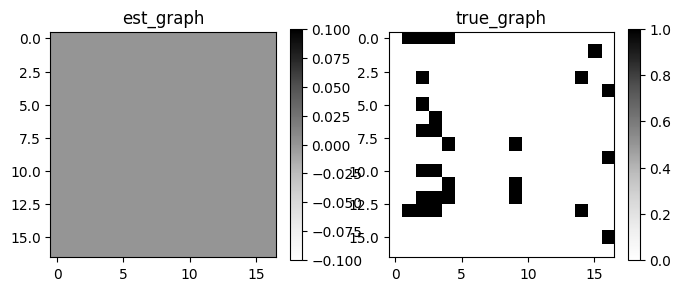

/home/flav/.local/lib/python3.10/site-packages/torch/distributions/distribution.py:51: UserWarning: <class 'causica.distributions.noise.joint.JointNoise'> does not define `arg_constraints`. Please set `arg_constraints = {}` or initialize the distribution with `validate_args=False` to turn off validation.
  warnings.warn(f'{self.__class__} does not define `arg_constraints`. ' +


epoch:10 loss:8.4176e+05 nll:8.4176e+05 dagness:102.73449 num_edges:119 alpha:0 rho:1 step:0|1711 num_lr_updates:2


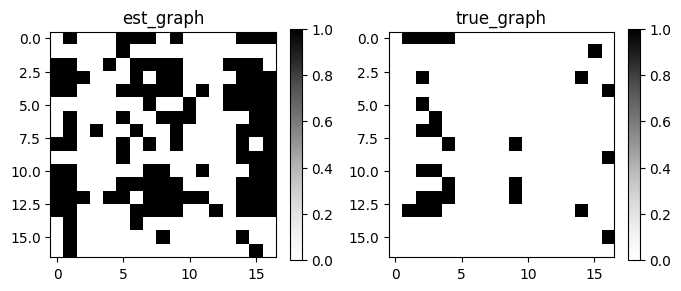

/home/flav/.local/lib/python3.10/site-packages/torch/distributions/distribution.py:51: UserWarning: <class 'causica.distributions.noise.joint.JointNoise'> does not define `arg_constraints`. Please set `arg_constraints = {}` or initialize the distribution with `validate_args=False` to turn off validation.
  warnings.warn(f'{self.__class__} does not define `arg_constraints`. ' +


Updating alpha to: 45.09846496582031
epoch:20 loss:1.984e+05 nll:1.984e+05 dagness:13.99656 num_edges:113 alpha:45.098 rho:1 step:1|1548 num_lr_updates:0


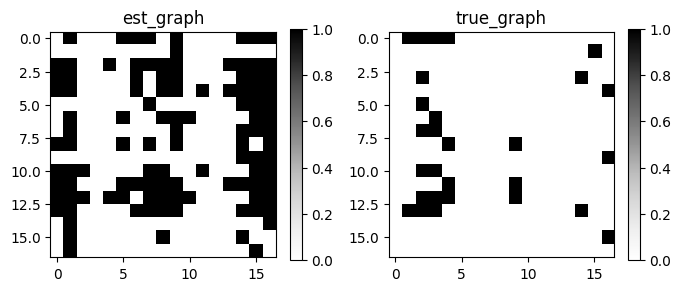

/home/flav/.local/lib/python3.10/site-packages/torch/distributions/distribution.py:51: UserWarning: <class 'causica.distributions.noise.joint.JointNoise'> does not define `arg_constraints`. Please set `arg_constraints = {}` or initialize the distribution with `validate_args=False` to turn off validation.
  warnings.warn(f'{self.__class__} does not define `arg_constraints`. ' +


Updating alpha to: 57.586008071899414
epoch:30 loss:7.4525e+09 nll:7.4525e+09 dagness:11.63354 num_edges:111 alpha:57.586 rho:1 step:2|258 num_lr_updates:0


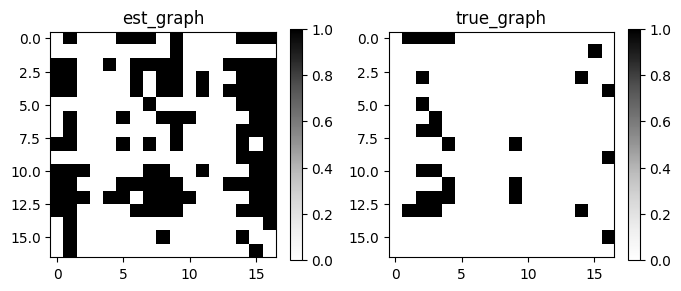

/home/flav/.local/lib/python3.10/site-packages/torch/distributions/distribution.py:51: UserWarning: <class 'causica.distributions.noise.joint.JointNoise'> does not define `arg_constraints`. Please set `arg_constraints = {}` or initialize the distribution with `validate_args=False` to turn off validation.
  warnings.warn(f'{self.__class__} does not define `arg_constraints`. ' +


Updating rho, dag penalty prev:  12.4875431061
epoch:40 loss:85165 nll:85165 dagness:11.56782 num_edges:109 alpha:57.586 rho:10 step:3|118 num_lr_updates:0


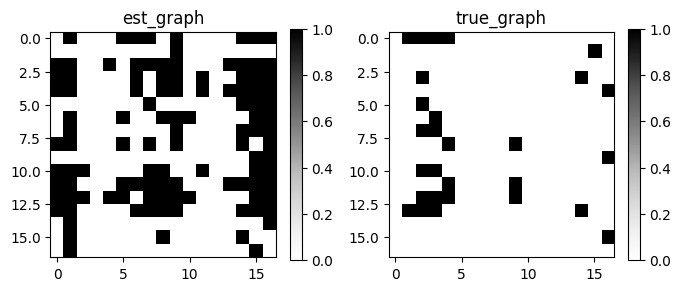

/home/flav/.local/lib/python3.10/site-packages/torch/distributions/distribution.py:51: UserWarning: <class 'causica.distributions.noise.joint.JointNoise'> does not define `arg_constraints`. Please set `arg_constraints = {}` or initialize the distribution with `validate_args=False` to turn off validation.
  warnings.warn(f'{self.__class__} does not define `arg_constraints`. ' +


epoch:50 loss:32345 nll:32345 dagness:26.16655 num_edges:107 alpha:57.586 rho:10 step:3|1828 num_lr_updates:1


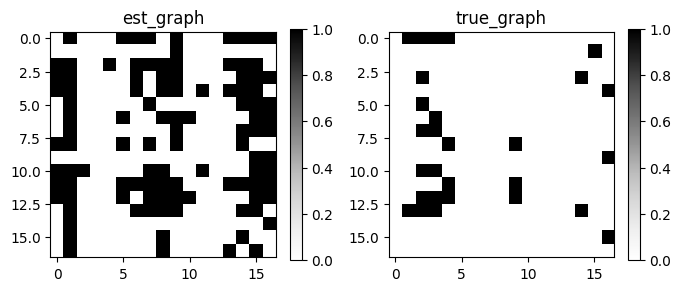

/home/flav/.local/lib/python3.10/site-packages/torch/distributions/distribution.py:51: UserWarning: <class 'causica.distributions.noise.joint.JointNoise'> does not define `arg_constraints`. Please set `arg_constraints = {}` or initialize the distribution with `validate_args=False` to turn off validation.
  warnings.warn(f'{self.__class__} does not define `arg_constraints`. ' +


Updating rho, dag penalty prev:  12.4875431061
epoch:60 loss:16651 nll:16651 dagness:14.62850 num_edges:102 alpha:57.586 rho:100 step:4|1034 num_lr_updates:1


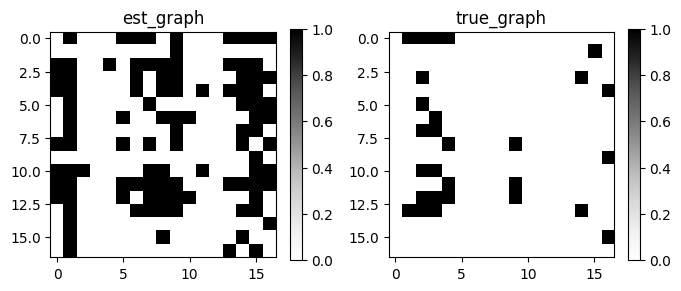

/home/flav/.local/lib/python3.10/site-packages/torch/distributions/distribution.py:51: UserWarning: <class 'causica.distributions.noise.joint.JointNoise'> does not define `arg_constraints`. Please set `arg_constraints = {}` or initialize the distribution with `validate_args=False` to turn off validation.
  warnings.warn(f'{self.__class__} does not define `arg_constraints`. ' +


Updating rho, dag penalty prev:  12.4875431061
epoch:70 loss:2.5197e+05 nll:2.5197e+05 dagness:23.02924 num_edges:105 alpha:57.586 rho:1000 step:5|556 num_lr_updates:0


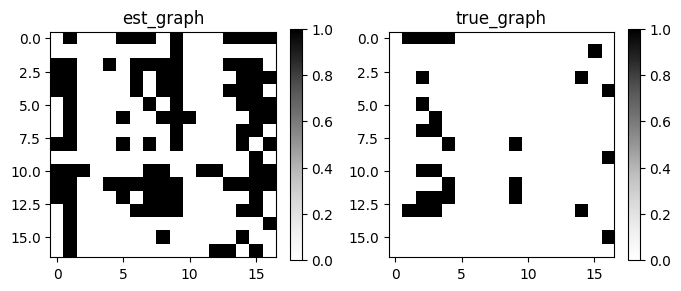

/home/flav/.local/lib/python3.10/site-packages/torch/distributions/distribution.py:51: UserWarning: <class 'causica.distributions.noise.joint.JointNoise'> does not define `arg_constraints`. Please set `arg_constraints = {}` or initialize the distribution with `validate_args=False` to turn off validation.
  warnings.warn(f'{self.__class__} does not define `arg_constraints`. ' +


epoch:80 loss:3.1783e+07 nll:3.1783e+07 dagness:17.35464 num_edges:102 alpha:57.586 rho:1000 step:5|2266 num_lr_updates:1


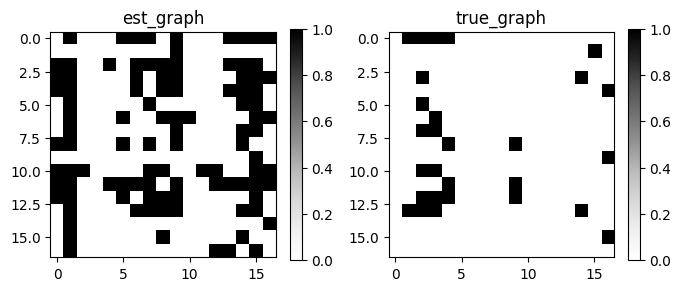

/home/flav/.local/lib/python3.10/site-packages/torch/distributions/distribution.py:51: UserWarning: <class 'causica.distributions.noise.joint.JointNoise'> does not define `arg_constraints`. Please set `arg_constraints = {}` or initialize the distribution with `validate_args=False` to turn off validation.
  warnings.warn(f'{self.__class__} does not define `arg_constraints`. ' +


Updating rho, dag penalty prev:  12.4875431061
epoch:90 loss:2207.3 nll:2207.3 dagness:17.72462 num_edges:103 alpha:57.586 rho:10000 step:6|1119 num_lr_updates:1


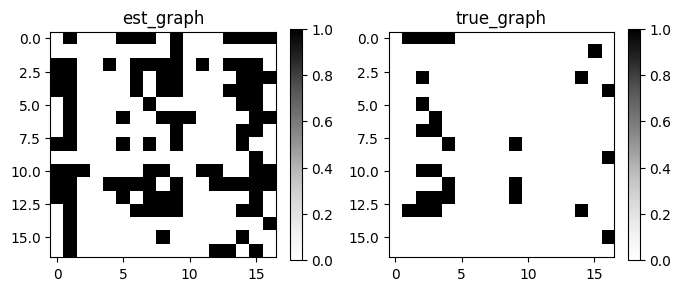

/home/flav/.local/lib/python3.10/site-packages/torch/distributions/distribution.py:51: UserWarning: <class 'causica.distributions.noise.joint.JointNoise'> does not define `arg_constraints`. Please set `arg_constraints = {}` or initialize the distribution with `validate_args=False` to turn off validation.
  warnings.warn(f'{self.__class__} does not define `arg_constraints`. ' +


Updating rho, dag penalty prev:  12.4875431061
epoch:100 loss:971.96 nll:971.95 dagness:11.65336 num_edges:100 alpha:57.586 rho:1e+05 step:7|1199 num_lr_updates:0


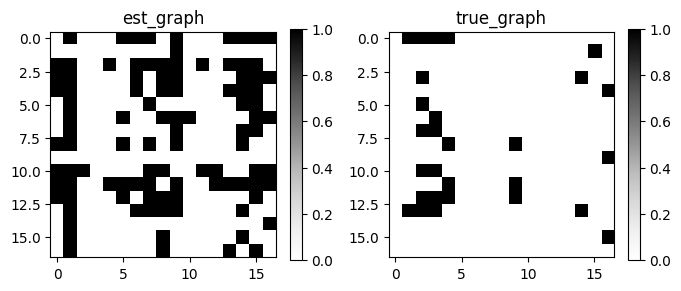

/home/flav/.local/lib/python3.10/site-packages/torch/distributions/distribution.py:51: UserWarning: <class 'causica.distributions.noise.joint.JointNoise'> does not define `arg_constraints`. Please set `arg_constraints = {}` or initialize the distribution with `validate_args=False` to turn off validation.
  warnings.warn(f'{self.__class__} does not define `arg_constraints`. ' +


Updating rho, dag penalty prev:  12.4875431061
epoch:110 loss:4.991e+06 nll:4.991e+06 dagness:9.22064 num_edges:97 alpha:57.586 rho:1e+06 step:8|423 num_lr_updates:0


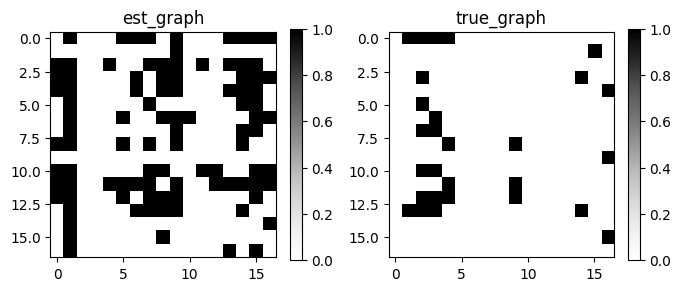

/home/flav/.local/lib/python3.10/site-packages/torch/distributions/distribution.py:51: UserWarning: <class 'causica.distributions.noise.joint.JointNoise'> does not define `arg_constraints`. Please set `arg_constraints = {}` or initialize the distribution with `validate_args=False` to turn off validation.
  warnings.warn(f'{self.__class__} does not define `arg_constraints`. ' +


Updating rho, dag penalty prev:  12.4875431061
epoch:120 loss:3.5355e+06 nll:3.5355e+06 dagness:8.91536 num_edges:95 alpha:57.586 rho:1e+07 step:9|283 num_lr_updates:0


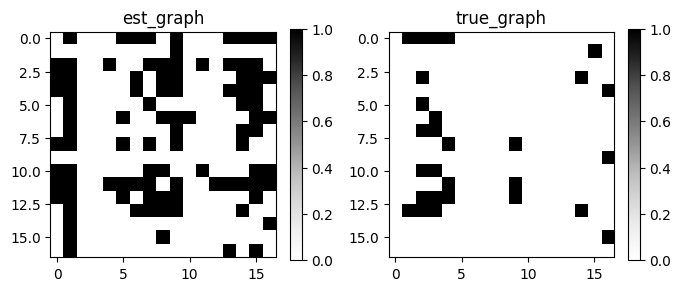

/home/flav/.local/lib/python3.10/site-packages/torch/distributions/distribution.py:51: UserWarning: <class 'causica.distributions.noise.joint.JointNoise'> does not define `arg_constraints`. Please set `arg_constraints = {}` or initialize the distribution with `validate_args=False` to turn off validation.
  warnings.warn(f'{self.__class__} does not define `arg_constraints`. ' +


epoch:130 loss:6497 nll:6496.9 dagness:8.86190 num_edges:96 alpha:57.586 rho:1e+07 step:9|1993 num_lr_updates:1


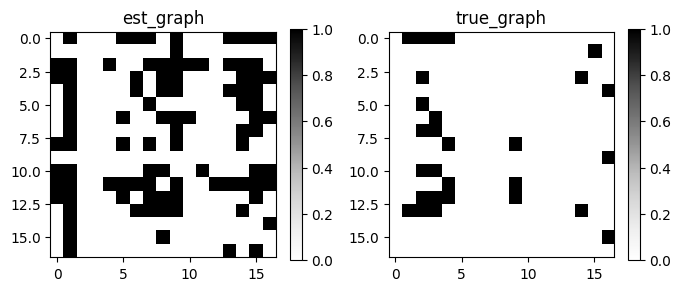

/home/flav/.local/lib/python3.10/site-packages/torch/distributions/distribution.py:51: UserWarning: <class 'causica.distributions.noise.joint.JointNoise'> does not define `arg_constraints`. Please set `arg_constraints = {}` or initialize the distribution with `validate_args=False` to turn off validation.
  warnings.warn(f'{self.__class__} does not define `arg_constraints`. ' +


Updating rho, dag penalty prev:  12.4875431061
epoch:140 loss:93.381 nll:93.175 dagness:5.48953 num_edges:92 alpha:57.586 rho:1e+08 step:10|703 num_lr_updates:0


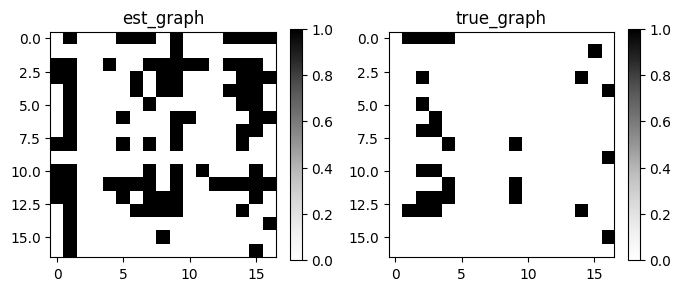

/home/flav/.local/lib/python3.10/site-packages/torch/distributions/distribution.py:51: UserWarning: <class 'causica.distributions.noise.joint.JointNoise'> does not define `arg_constraints`. Please set `arg_constraints = {}` or initialize the distribution with `validate_args=False` to turn off validation.
  warnings.warn(f'{self.__class__} does not define `arg_constraints`. ' +


Updating alpha to: 548952923.186594
epoch:150 loss:56.411 nll:56.406 dagness:0.00000 num_edges:81 alpha:5.4895e+08 rho:1e+08 step:11|928 num_lr_updates:0


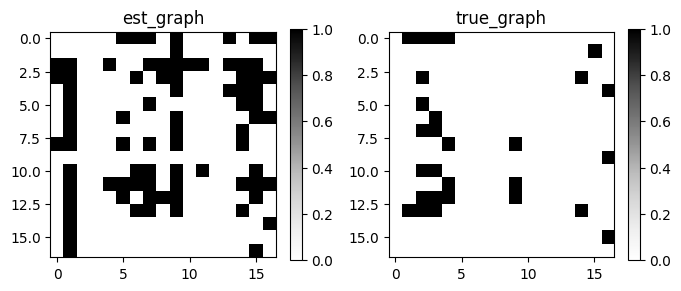

/home/flav/.local/lib/python3.10/site-packages/torch/distributions/distribution.py:51: UserWarning: <class 'causica.distributions.noise.joint.JointNoise'> does not define `arg_constraints`. Please set `arg_constraints = {}` or initialize the distribution with `validate_args=False` to turn off validation.
  warnings.warn(f'{self.__class__} does not define `arg_constraints`. ' +


epoch:160 loss:46.419 nll:46.415 dagness:0.00000 num_edges:79 alpha:5.4895e+08 rho:1e+08 step:11|2638 num_lr_updates:2


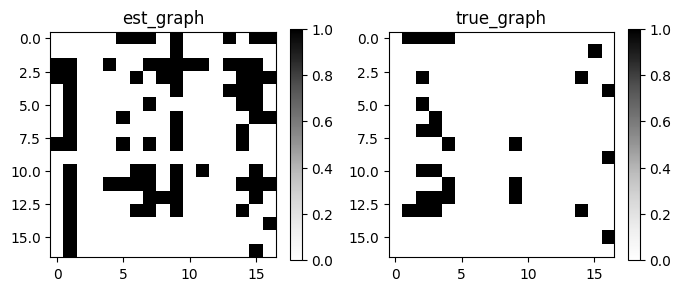

/home/flav/.local/lib/python3.10/site-packages/torch/distributions/distribution.py:51: UserWarning: <class 'causica.distributions.noise.joint.JointNoise'> does not define `arg_constraints`. Please set `arg_constraints = {}` or initialize the distribution with `validate_args=False` to turn off validation.
  warnings.warn(f'{self.__class__} does not define `arg_constraints`. ' +


Updating alpha to: 2744764615.93297
epoch:170 loss:39.172 nll:39.167 dagness:0.00000 num_edges:82 alpha:2.7448e+09 rho:1e+08 step:12|1377 num_lr_updates:2


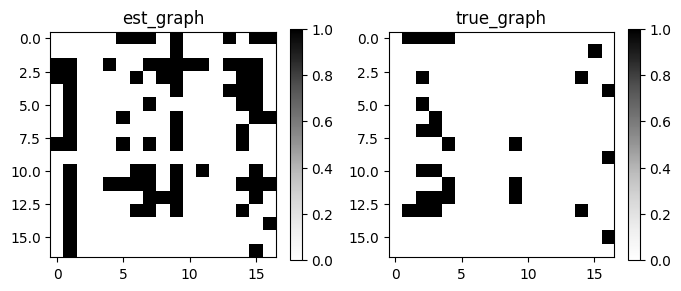

/home/flav/.local/lib/python3.10/site-packages/torch/distributions/distribution.py:51: UserWarning: <class 'causica.distributions.noise.joint.JointNoise'> does not define `arg_constraints`. Please set `arg_constraints = {}` or initialize the distribution with `validate_args=False` to turn off validation.
  warnings.warn(f'{self.__class__} does not define `arg_constraints`. ' +


Updating alpha to: 13723823079.66485
epoch:180 loss:40.812 nll:40.807 dagness:0.00000 num_edges:77 alpha:1.3724e+10 rho:1e+08 step:13|1408 num_lr_updates:2


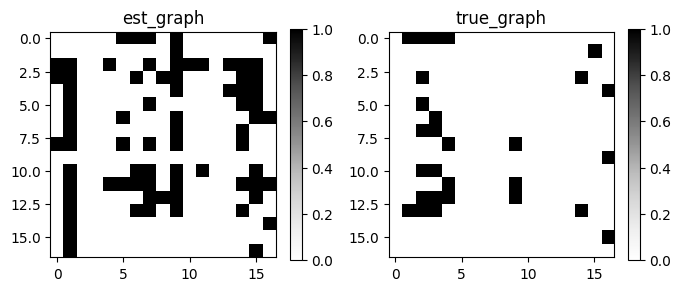

/home/flav/.local/lib/python3.10/site-packages/torch/distributions/distribution.py:51: UserWarning: <class 'causica.distributions.noise.joint.JointNoise'> does not define `arg_constraints`. Please set `arg_constraints = {}` or initialize the distribution with `validate_args=False` to turn off validation.
  warnings.warn(f'{self.__class__} does not define `arg_constraints`. ' +


Updating alpha to: 68619115398.32425
epoch:190 loss:38.694 nll:38.69 dagness:0.00000 num_edges:77 alpha:6.8619e+10 rho:1e+08 step:14|1328 num_lr_updates:2


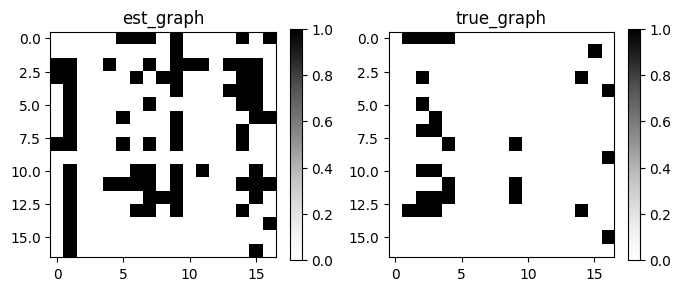

/home/flav/.local/lib/python3.10/site-packages/torch/distributions/distribution.py:51: UserWarning: <class 'causica.distributions.noise.joint.JointNoise'> does not define `arg_constraints`. Please set `arg_constraints = {}` or initialize the distribution with `validate_args=False` to turn off validation.
  warnings.warn(f'{self.__class__} does not define `arg_constraints`. ' +


Updating alpha to: 343095576991.6212
epoch:200 loss:30.371 nll:30.366 dagness:0.00000 num_edges:78 alpha:3.431e+11 rho:1e+08 step:15|1262 num_lr_updates:1


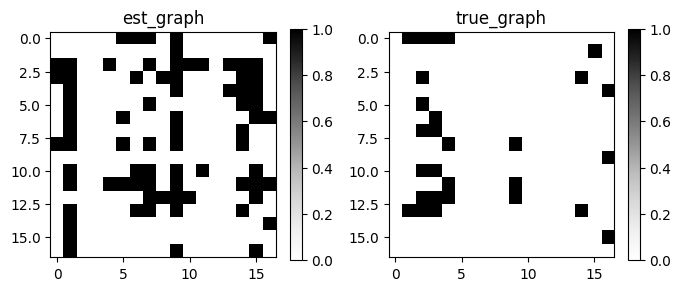

/home/flav/.local/lib/python3.10/site-packages/torch/distributions/distribution.py:51: UserWarning: <class 'causica.distributions.noise.joint.JointNoise'> does not define `arg_constraints`. Please set `arg_constraints = {}` or initialize the distribution with `validate_args=False` to turn off validation.
  warnings.warn(f'{self.__class__} does not define `arg_constraints`. ' +


Updating alpha to: 1715477884958.106
epoch:210 loss:37.32 nll:37.316 dagness:0.00000 num_edges:77 alpha:1.7155e+12 rho:1e+08 step:16|569 num_lr_updates:0


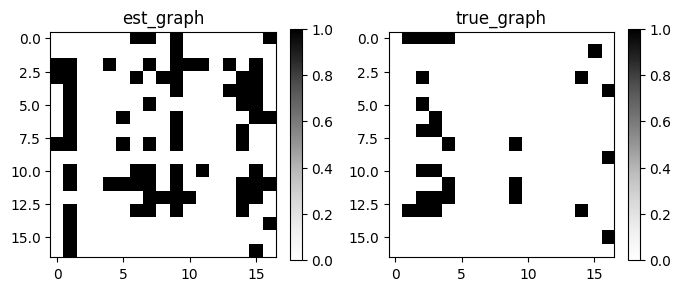

/home/flav/.local/lib/python3.10/site-packages/torch/distributions/distribution.py:51: UserWarning: <class 'causica.distributions.noise.joint.JointNoise'> does not define `arg_constraints`. Please set `arg_constraints = {}` or initialize the distribution with `validate_args=False` to turn off validation.
  warnings.warn(f'{self.__class__} does not define `arg_constraints`. ' +


epoch:220 loss:28.58 nll:28.575 dagness:0.00000 num_edges:74 alpha:1.7155e+12 rho:1e+08 step:16|2279 num_lr_updates:2


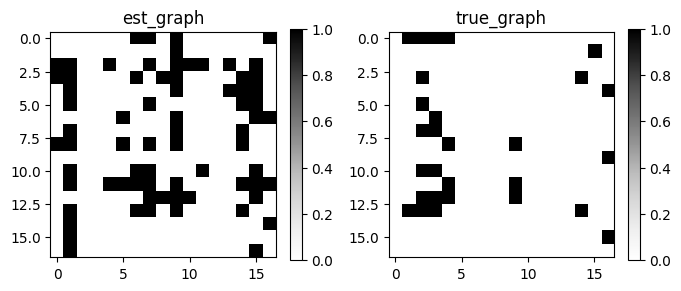

/home/flav/.local/lib/python3.10/site-packages/torch/distributions/distribution.py:51: UserWarning: <class 'causica.distributions.noise.joint.JointNoise'> does not define `arg_constraints`. Please set `arg_constraints = {}` or initialize the distribution with `validate_args=False` to turn off validation.
  warnings.warn(f'{self.__class__} does not define `arg_constraints`. ' +


epoch:230 loss:29.424 nll:29.42 dagness:0.00000 num_edges:72 alpha:1.7155e+12 rho:1e+08 step:16|3989 num_lr_updates:3


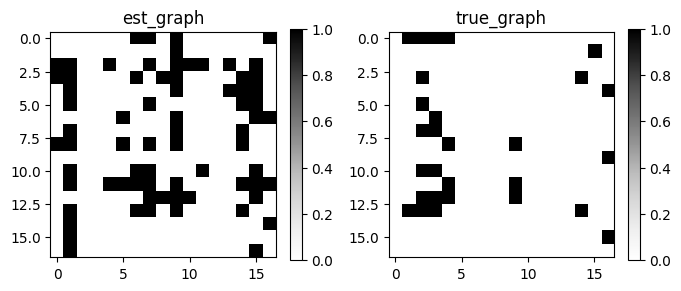

/home/flav/.local/lib/python3.10/site-packages/torch/distributions/distribution.py:51: UserWarning: <class 'causica.distributions.noise.joint.JointNoise'> does not define `arg_constraints`. Please set `arg_constraints = {}` or initialize the distribution with `validate_args=False` to turn off validation.
  warnings.warn(f'{self.__class__} does not define `arg_constraints`. ' +


epoch:240 loss:27.421 nll:27.417 dagness:0.00000 num_edges:74 alpha:1.7155e+12 rho:1e+08 step:16|5699 num_lr_updates:3


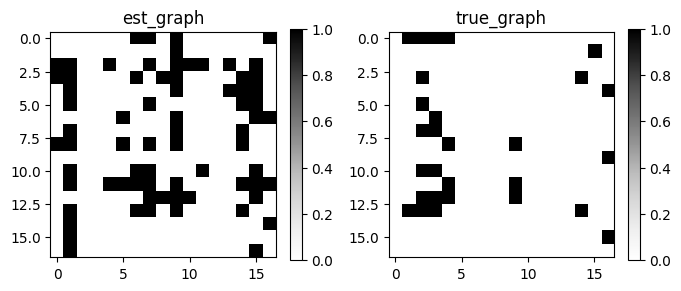

/home/flav/.local/lib/python3.10/site-packages/torch/distributions/distribution.py:51: UserWarning: <class 'causica.distributions.noise.joint.JointNoise'> does not define `arg_constraints`. Please set `arg_constraints = {}` or initialize the distribution with `validate_args=False` to turn off validation.
  warnings.warn(f'{self.__class__} does not define `arg_constraints`. ' +


epoch:250 loss:30.296 nll:30.292 dagness:0.00000 num_edges:73 alpha:1.7155e+12 rho:1e+08 step:16|7409 num_lr_updates:3


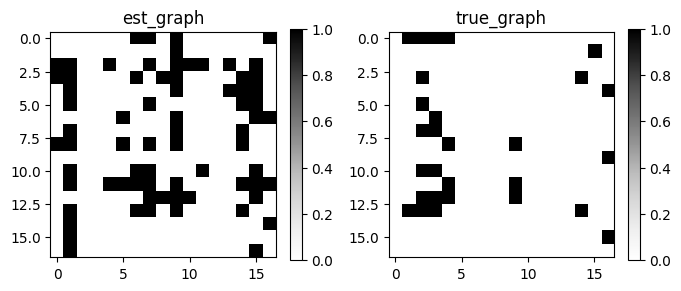

/home/flav/.local/lib/python3.10/site-packages/torch/distributions/distribution.py:51: UserWarning: <class 'causica.distributions.noise.joint.JointNoise'> does not define `arg_constraints`. Please set `arg_constraints = {}` or initialize the distribution with `validate_args=False` to turn off validation.
  warnings.warn(f'{self.__class__} does not define `arg_constraints`. ' +


epoch:260 loss:33.744 nll:33.74 dagness:0.00000 num_edges:72 alpha:1.7155e+12 rho:1e+08 step:16|9119 num_lr_updates:3


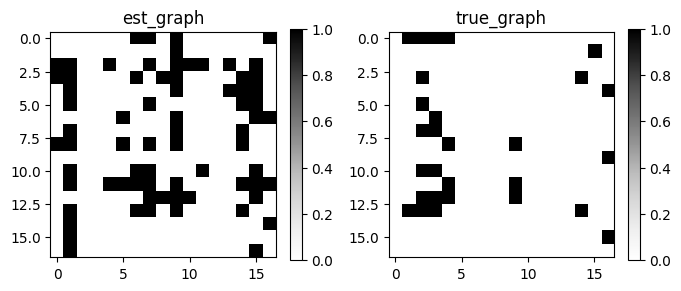

/home/flav/.local/lib/python3.10/site-packages/torch/distributions/distribution.py:51: UserWarning: <class 'causica.distributions.noise.joint.JointNoise'> does not define `arg_constraints`. Please set `arg_constraints = {}` or initialize the distribution with `validate_args=False` to turn off validation.
  warnings.warn(f'{self.__class__} does not define `arg_constraints`. ' +


epoch:270 loss:27.405 nll:27.401 dagness:0.00000 num_edges:73 alpha:1.7155e+12 rho:1e+08 step:16|10829 num_lr_updates:3


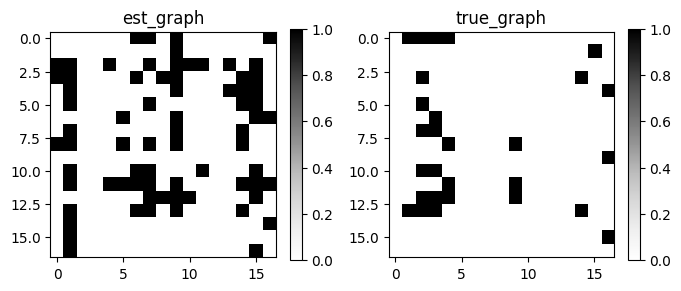

/home/flav/.local/lib/python3.10/site-packages/torch/distributions/distribution.py:51: UserWarning: <class 'causica.distributions.noise.joint.JointNoise'> does not define `arg_constraints`. Please set `arg_constraints = {}` or initialize the distribution with `validate_args=False` to turn off validation.
  warnings.warn(f'{self.__class__} does not define `arg_constraints`. ' +


epoch:280 loss:27.305 nll:27.301 dagness:0.00000 num_edges:72 alpha:1.7155e+12 rho:1e+08 step:16|12539 num_lr_updates:3


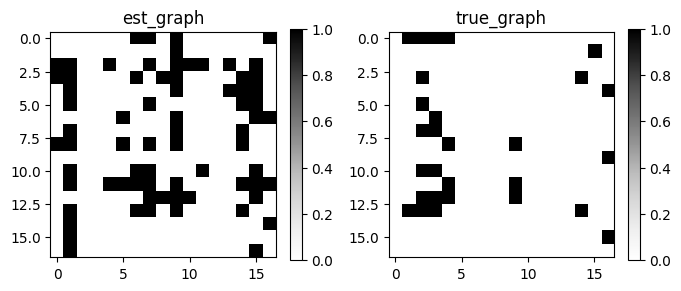

/home/flav/.local/lib/python3.10/site-packages/torch/distributions/distribution.py:51: UserWarning: <class 'causica.distributions.noise.joint.JointNoise'> does not define `arg_constraints`. Please set `arg_constraints = {}` or initialize the distribution with `validate_args=False` to turn off validation.
  warnings.warn(f'{self.__class__} does not define `arg_constraints`. ' +


epoch:290 loss:27.01 nll:27.005 dagness:0.00000 num_edges:74 alpha:1.7155e+12 rho:1e+08 step:16|14249 num_lr_updates:3


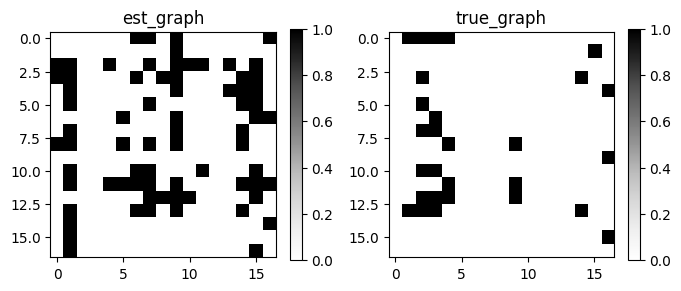

/home/flav/.local/lib/python3.10/site-packages/torch/distributions/distribution.py:51: UserWarning: <class 'causica.distributions.noise.joint.JointNoise'> does not define `arg_constraints`. Please set `arg_constraints = {}` or initialize the distribution with `validate_args=False` to turn off validation.
  warnings.warn(f'{self.__class__} does not define `arg_constraints`. ' +


epoch:300 loss:28.296 nll:28.292 dagness:0.00000 num_edges:75 alpha:1.7155e+12 rho:1e+08 step:16|15959 num_lr_updates:3


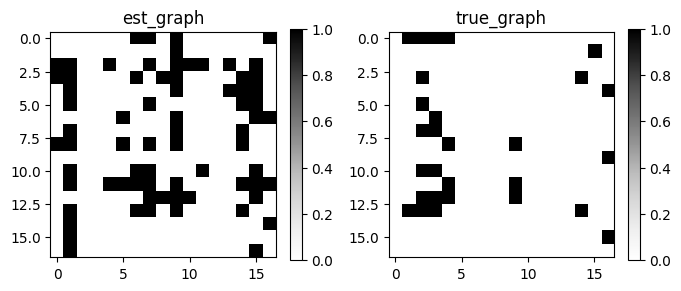

/home/flav/.local/lib/python3.10/site-packages/torch/distributions/distribution.py:51: UserWarning: <class 'causica.distributions.noise.joint.JointNoise'> does not define `arg_constraints`. Please set `arg_constraints = {}` or initialize the distribution with `validate_args=False` to turn off validation.
  warnings.warn(f'{self.__class__} does not define `arg_constraints`. ' +


epoch:310 loss:26.432 nll:26.427 dagness:0.00000 num_edges:74 alpha:1.7155e+12 rho:1e+08 step:16|17669 num_lr_updates:3


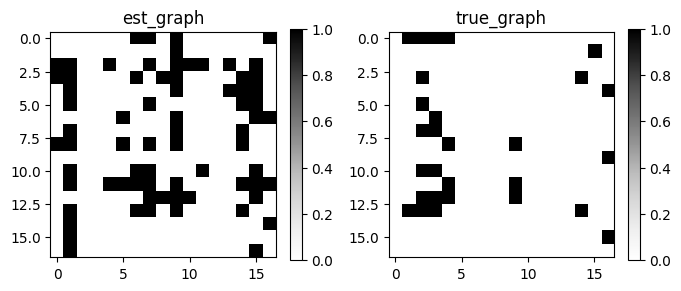

/home/flav/.local/lib/python3.10/site-packages/torch/distributions/distribution.py:51: UserWarning: <class 'causica.distributions.noise.joint.JointNoise'> does not define `arg_constraints`. Please set `arg_constraints = {}` or initialize the distribution with `validate_args=False` to turn off validation.
  warnings.warn(f'{self.__class__} does not define `arg_constraints`. ' +


epoch:320 loss:25.838 nll:25.834 dagness:0.00000 num_edges:73 alpha:1.7155e+12 rho:1e+08 step:16|19379 num_lr_updates:3


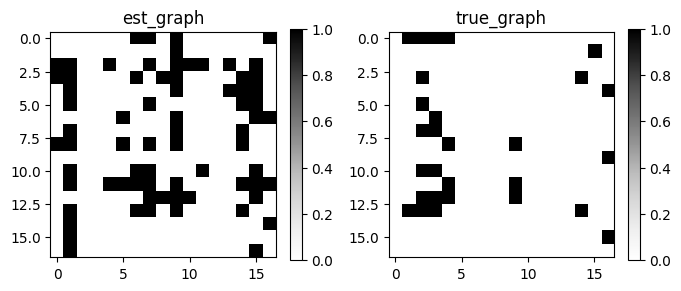

/home/flav/.local/lib/python3.10/site-packages/torch/distributions/distribution.py:51: UserWarning: <class 'causica.distributions.noise.joint.JointNoise'> does not define `arg_constraints`. Please set `arg_constraints = {}` or initialize the distribution with `validate_args=False` to turn off validation.
  warnings.warn(f'{self.__class__} does not define `arg_constraints`. ' +


epoch:330 loss:26.228 nll:26.224 dagness:0.00000 num_edges:74 alpha:1.7155e+12 rho:1e+08 step:16|21089 num_lr_updates:3


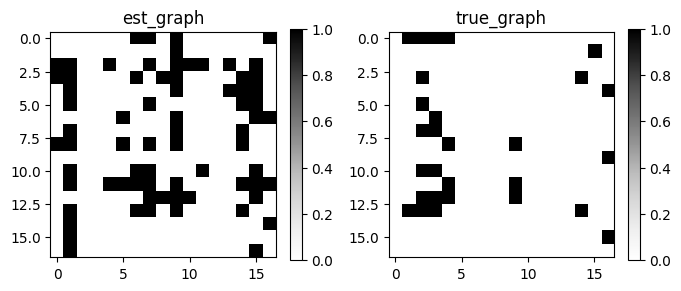

/home/flav/.local/lib/python3.10/site-packages/torch/distributions/distribution.py:51: UserWarning: <class 'causica.distributions.noise.joint.JointNoise'> does not define `arg_constraints`. Please set `arg_constraints = {}` or initialize the distribution with `validate_args=False` to turn off validation.
  warnings.warn(f'{self.__class__} does not define `arg_constraints`. ' +


epoch:340 loss:26.037 nll:26.033 dagness:0.00000 num_edges:74 alpha:1.7155e+12 rho:1e+08 step:16|22799 num_lr_updates:3


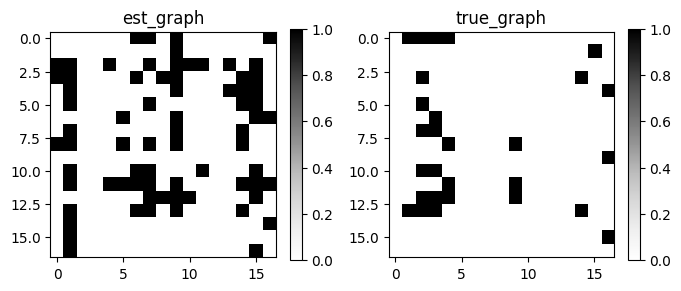

/home/flav/.local/lib/python3.10/site-packages/torch/distributions/distribution.py:51: UserWarning: <class 'causica.distributions.noise.joint.JointNoise'> does not define `arg_constraints`. Please set `arg_constraints = {}` or initialize the distribution with `validate_args=False` to turn off validation.
  warnings.warn(f'{self.__class__} does not define `arg_constraints`. ' +


epoch:350 loss:25.554 nll:25.55 dagness:0.00000 num_edges:74 alpha:1.7155e+12 rho:1e+08 step:16|24509 num_lr_updates:3


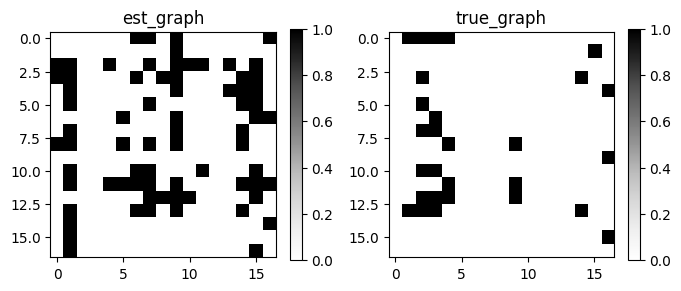

/home/flav/.local/lib/python3.10/site-packages/torch/distributions/distribution.py:51: UserWarning: <class 'causica.distributions.noise.joint.JointNoise'> does not define `arg_constraints`. Please set `arg_constraints = {}` or initialize the distribution with `validate_args=False` to turn off validation.
  warnings.warn(f'{self.__class__} does not define `arg_constraints`. ' +


ValueError: Expected value argument (Tensor of shape (512, 1)) to be within the support (Real()) of the distribution Normal(loc: torch.Size([512, 1]), scale: torch.Size([512, 1])), but found invalid values:
tensor([[nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan]], grad_fn=<DivBackward0>)

In [19]:
assert len(dataset_train.batch_size) == 1, "Only 1D batch size is supported"

num_samples = len(dataset_train)

for epoch in range(training_config.max_epoch):
    
    for i, batch in enumerate(dataloader_train):
        
        # Zero the gradients
        optimizer.zero_grad()
        
        # Get SEM 
        sem_distribution = sem_module()
        sem, *_ = sem_distribution.relaxed_sample(
            torch.Size([]), 
            temperature=training_config.gumbel_temp
        )  # soft sample
        
        # Compute the log probability of data
        batch_log_prob = sem.log_prob(batch).mean()
        
        # Get the distribution entropy
        sem_distribution_entropy = sem_distribution.entropy()
        
        # Compute the likelihood of the current graph
        prior_term = prior.log_prob(sem.graph)
        
        # Compute the objective
        objective = (-sem_distribution_entropy - prior_term) / num_samples - batch_log_prob
        
        # Compute the DAG-ness term
        constraint = calculate_dagness(sem.graph)
        
        # Compute the Lagrangian loss
        loss = auglag_loss(objective, constraint / num_samples)

        # Propagate gradients and update
        loss.backward()
        optimizer.step()
        
        # Update the Auglag parameters
        scheduler.step(
            optimizer=optimizer,
            loss=auglag_loss,
            loss_value=loss.item(),
            lagrangian_penalty=constraint.item(),
        )
        
        # Log metrics & plot the matrices
        if epoch % 10 == 0 and i == 0:
            print(
                f"epoch:{epoch} loss:{loss.item():.5g} nll:{-batch_log_prob.detach().cpu().numpy():.5g} "
                f"dagness:{constraint.item():.5f} num_edges:{(sem.graph > 0.0).sum()} "
                f"alpha:{auglag_loss.alpha:.5g} rho:{auglag_loss.rho:.5g} "
                f"step:{scheduler.outer_opt_counter}|{scheduler.step_counter} "
                f"num_lr_updates:{scheduler.num_lr_updates}"
            )
            
            vardist = adjacency_dist()
            pred_dag = vardist.mode.cpu().numpy()

            plt.style.use('default')

            GraphDAG(
                est_dag=pred_dag, 
                true_dag=adj_matrix)

            plt.show()

In [ ]:
# Sample from the distribution of graphs
vardist = adjacency_dist()
pred_dag = vardist.mode.cpu().numpy()


# Plot the final graph vs the ground truth
plt.style.use('default')

GraphDAG(
    est_dag=pred_dag, 
    true_dag=adj_matrix)

plt.show()

In [ ]:
# Compute and print the metrics
metrics = MetricsDAG(
    B_est=pred_dag, 
    B_true=adj_matrix)

metrics.metrics

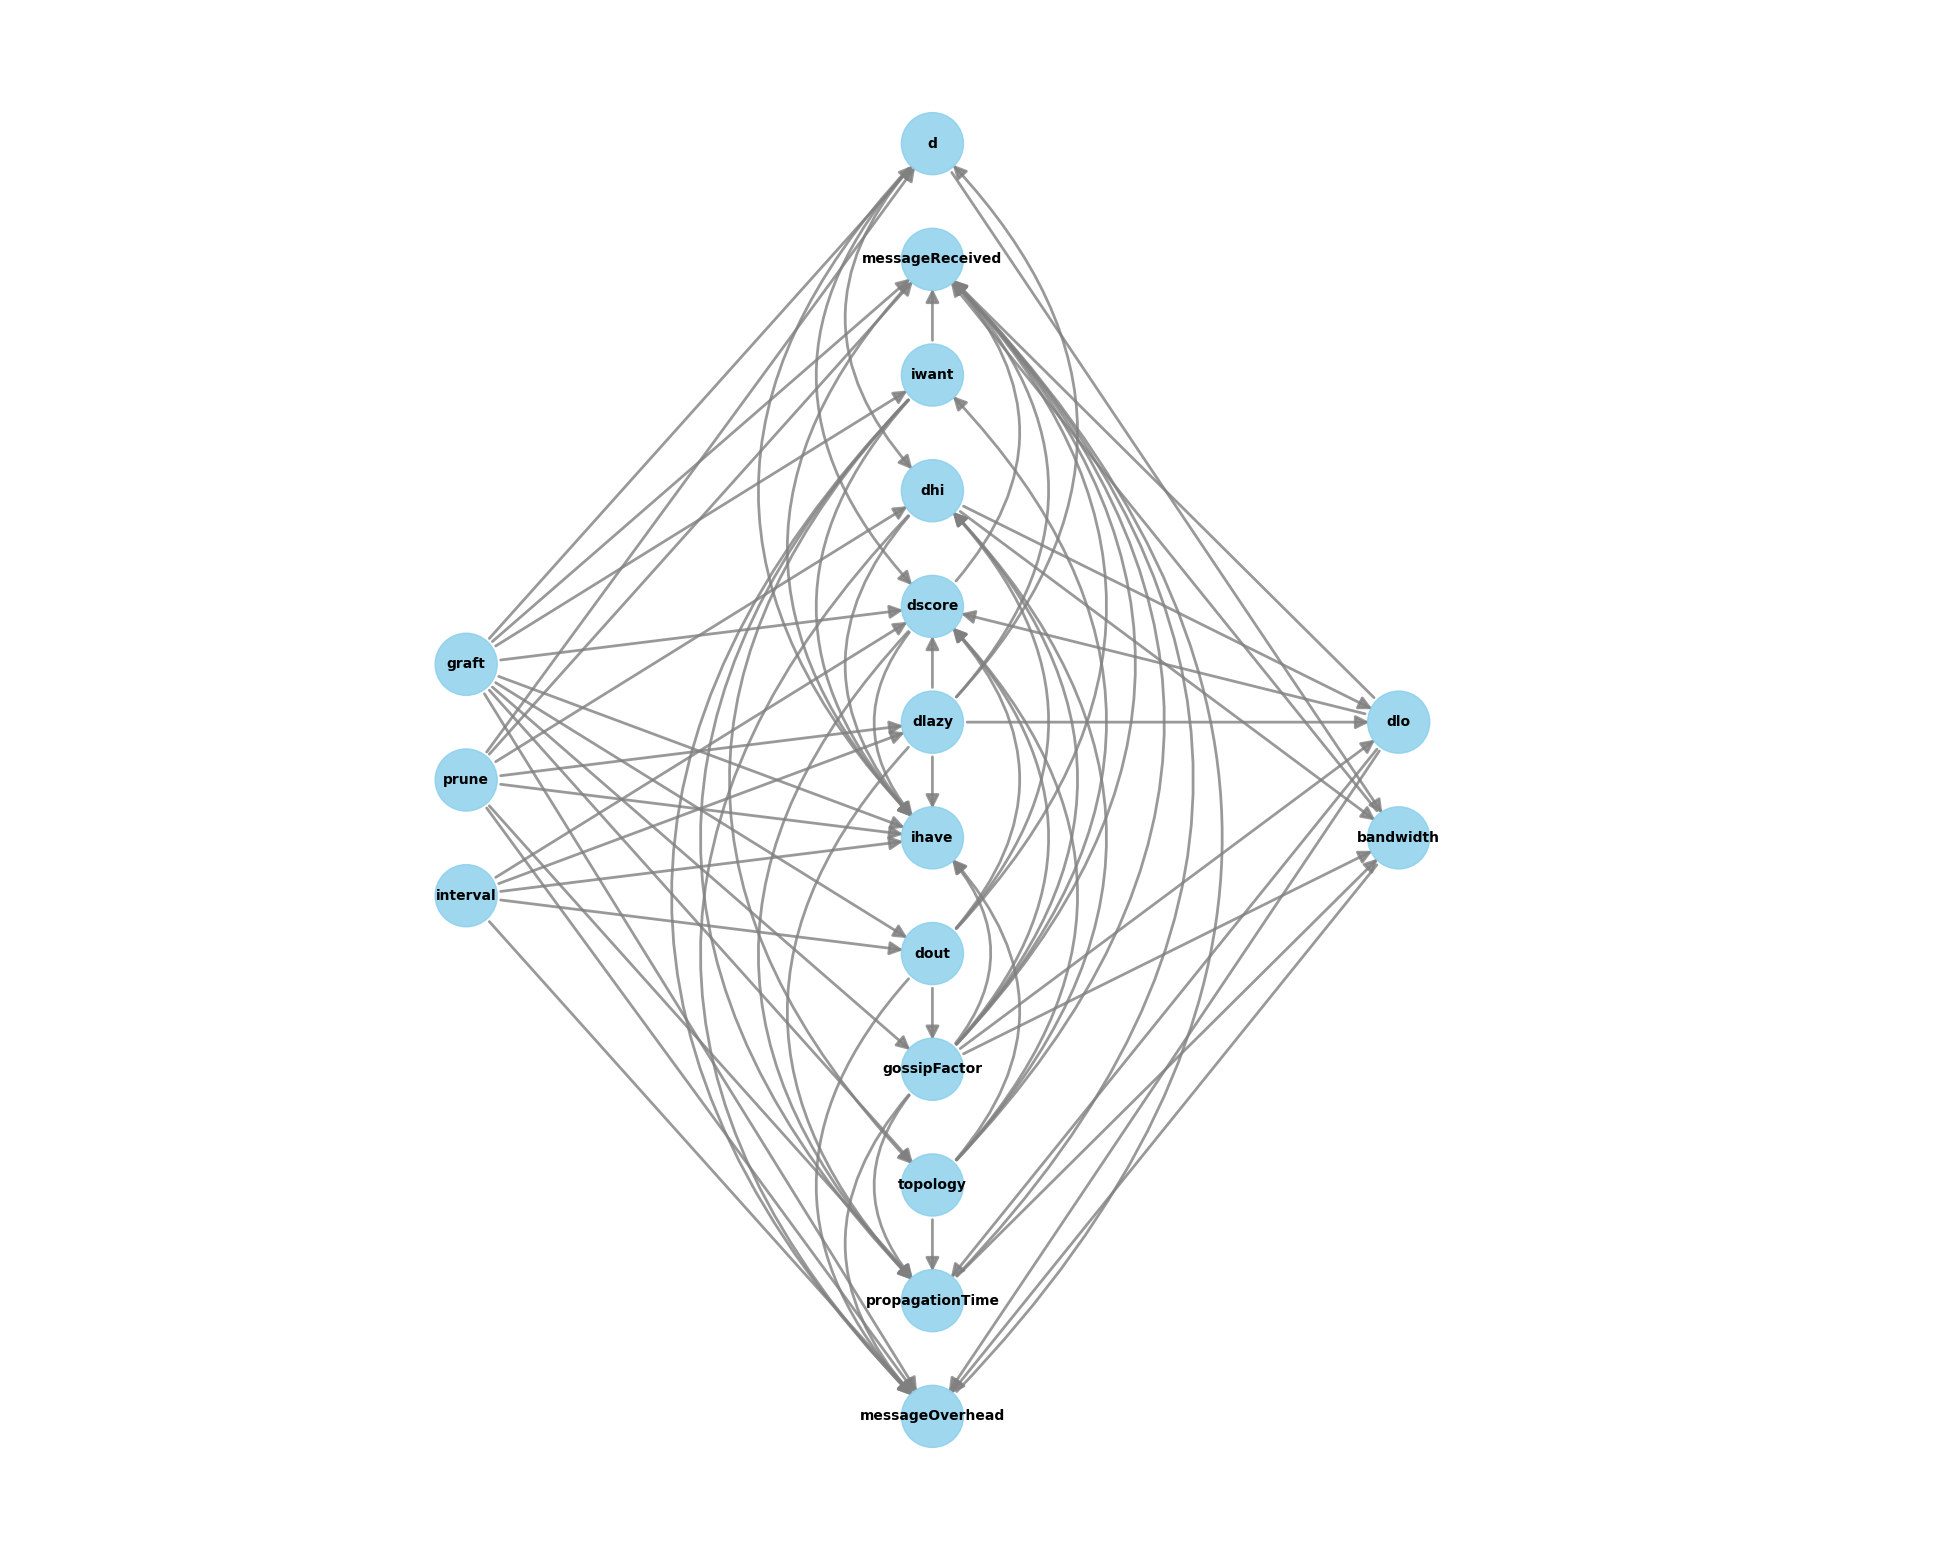

In [22]:
learned_causal_graph =  nx.from_numpy_array(pred_dag, create_using=nx.DiGraph)

mapping = {0:'d', 1:'messageReceived', 2:'graft', 3:'prune', 4:'iwant', 5:'dlo', 6:'dhi', 7:'dscore', 8:'dlazy', 9:'ihave', 10:'dout', 11:'gossipFactor', 12:'interval', 13:'topology', 14:'propagationTime', 15:'messageOverhead', 16:'bandwidth'}
# nx.set_node_attributes(learned_causal_graph, labels, "name")
H = nx.relabel_nodes(learned_causal_graph, mapping)

nx.write_adjlist(H, "deci.adjlist")

# fig, ax = plt.subplots(figsize=(15,20)) 
gcm.util.plot(H, figure_size=[25, 20])